# Assignment #5 (demo). Logistic Regression and Random Forest in the credit scoring problem

## Credit scoring problem setup

In [1]:
# setting up the environment
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from matplotlib import rcParams
rcParams["figure.figsize"] = 11, 8

In [2]:
# let's write a function that replaces all NaN values with the median
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [3]:
# reading the data
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"
data = pd.read_csv(DATA_PATH + 'credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
# inspecting variable types
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

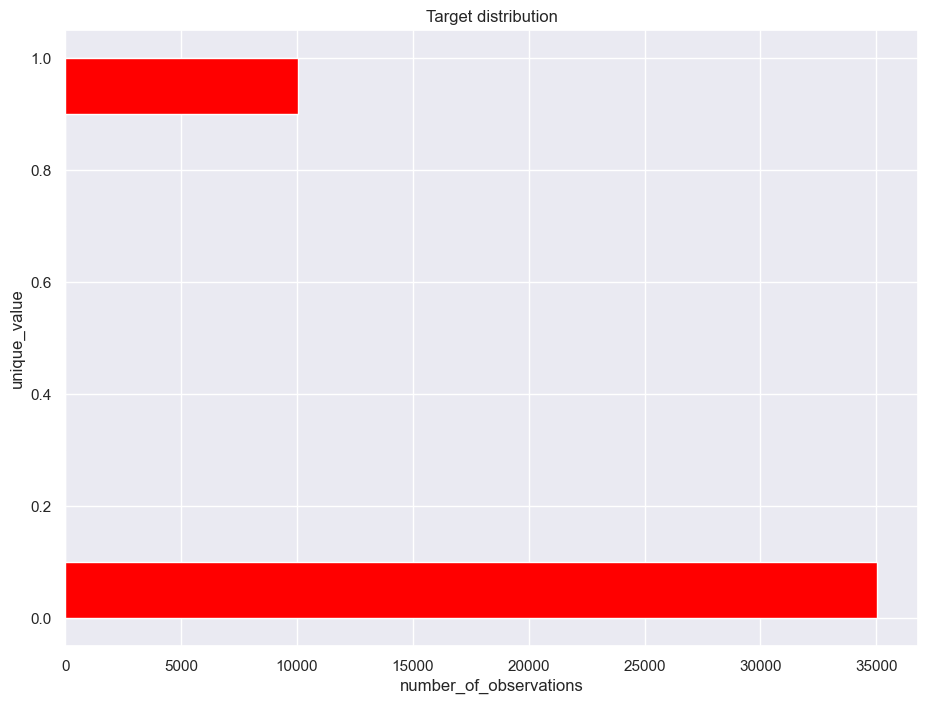

In [5]:
# checking the class balance
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel('number_of_observations')
ax.set_ylabel("unique_value")
ax.set_title("Target distribution");

In [6]:
print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

In [7]:
columns_names = [x for x in data if x !="SeriousDlqin2yrs"]
columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [8]:
# replacing NaN values
table = fill_nan(data)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         45063 non-null  float64
 7   NumberOfDependents                    45063 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


In [9]:
# separating target variable and input features
X = table[columns_names]
y = table["SeriousDlqin2yrs"]

## Bootstrapping

### Question 2. Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. What is the resulting interval estimate?

In [10]:
# setting the numpy seed for reproducibility
np.random.seed(0)

In [11]:
# defining helper functions
def bootstrap_samples(data, n_samples):
    """Generates and returns bootstrap samples"""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Returns an interval estimate"""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


In [12]:
serious_delays = table[table["SeriousDlqin2yrs"] == 1]
age_ser_del = serious_delays['age'].values
# generating samples and calculating the average value
mean_age = [
    np.mean(smpls) for smpls in bootstrap_samples(age_ser_del, 1000)
]
mean_age[:5]

[46.08238579692799,
 45.910931577897465,
 45.82535407939358,
 45.80051865150608,
 45.77488529822462]

In [13]:
# calculating the interval estimate with alpha 10%
interval_estimate = stat_intervals(mean_age, 0.1)
interval_estimate

array([45.71379414, 46.12700479])

## Logistic regression

In [14]:
# setting up for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [15]:
# creating a log regression model and balance out the classes
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [16]:
# creating a parameter grid
parameters = {
    "C": (0.0001, 0.001, 0.01, 0.1, 1, 10)
}

In [18]:
# creating a stratified 5-fold 
skf  = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

### Question 3. Perform a Grid Search with the scoring metric “roc_auc” for the parameter C. Which value of the parameter C is optimal?

In [23]:
# applying the Grid Search
grid = GridSearchCV(
    lr, parameters,  scoring="roc_auc", cv=skf, n_jobs=-1
)

In [24]:
grid.fit(X, y);

/home/oskorusha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/oskorusha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [25]:
grid.best_estimator_

LogisticRegression(C=10, class_weight='balanced', random_state=5)

### Question 4. Can we consider the best model stable? The model is stable if the standard deviation on validation is less than 0.5%. Save the ROC AUC value of the best model; it will be useful for the following tasks.

In [28]:
# let's explore the values of STD
grid.cv_results_['std_test_score']

array([0.00512258, 0.0073826 , 0.00583799, 0.0058729 , 0.00478471,
       0.00652446])

In [30]:
roc_auc = grid.best_score_
roc_auc

0.7961141646773107

## Feature importance

In [32]:
from sklearn.preprocessing import StandardScaler

### Question 5. Feature importance is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?

In [69]:
# normalizing the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [70]:
# fitting the logistic regression model
lr = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
lr.fit(X_normalized, y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [71]:
# retrieving the coefficients
coefs = lr.coef_[0]
coefs

array([-0.41711545,  0.7234213 , -0.02406798,  0.51665554,  0.19548607,
       -0.16301483,  0.10172163])

In [72]:
importance = abs(coefs)
most_important_feature = columns_names[importance.argmax()]

In [73]:
most_important_feature

'NumberOfTime30-59DaysPastDueNotWorse'

### Question 6. Calculate how much DebtRatio affects our prediction using the softmax function. What is its value?

In [78]:
debtratio_coef = coefs[columns_names.index('DebtRatio')]

In [79]:
debtratio_coef

-0.02406797791420995

In [80]:
softmax_value = np.exp(debtratio_coef)/ np.sum([np.exp(coef) for coef in coefs])

In [81]:
softmax_value

0.11423641577786525

### Question 7. Let’s see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer’s age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? 

In [99]:
# fitting logistic regression without scaling
lr.fit(X, y)


LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [100]:
# retrieving the age coefficient
age_coef = lr.coef_[0][columns_names.index('age')]
age_coef

-0.014589781138669402

In [102]:
# as we are working with a regression model the form of our orig_pred - aged_pred
# will be as follows delta = coef*delta_of_age
# because y = c1*f1 + c2*f2 + ...
log_change = age_coef * 20
log_change

-0.29179562277338805

In [103]:
np.exp(log_change)

0.7469211740530028

## Random Forest